In [10]:
import torch
SEED = 123
torch.manual_seed(SEED) 

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torchsummary import summary
from torchinfo import summary
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import warnings
from tqdm import tqdm
from datetime import datetime
from torch.autograd import Variable
warnings.filterwarnings('ignore')

from PIL import Image
import os
import glob

# check OS is Window or Mac
import platform
device = torch.device("cpu")

if platform.system() == 'Windows':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif platform.system() == 'Darwin':
    try:
        device = torch.device("mps")
    except:
        device = torch.device("cpu")

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind': float_formatter})

print(device)

cpu


In [3]:
class CustomFCNetwork(nn.Module):
    def __init__(self):
        super(CustomFCNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(19200, 128)  # Update fc1 input size to match the expected size
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 60)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            # 1
            nn.Conv2d(in_channels=3,    # cantidad de canales RGB == 3
                      out_channels=6, 
                      kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # 2
            nn.Conv2d(in_channels=6, 
                      out_channels=16,
                      kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*22*22, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

In [4]:
try:
    modelFCN = CustomFCNetwork()
    model_name = "FCN_final"
    modelFCN.load_state_dict(torch.load(f"models/best_model_{model_name}.pth", map_location=torch.device('cpu')))
    modelFCN.eval()  # Set model to evaluation mode after loading
except Exception as e:
    print(f"Error: {e}")


In [5]:
try:
    modelCNN = LeNet5V1()
    model_name = "LeNet5_final"
    modelCNN.load_state_dict(torch.load(f"models/best_model_{model_name}.pth", map_location=torch.device('cpu')))
    modelCNN.eval()  # Set model to evaluation mode after loading
except Exception as e:
    print(f"Error: {e}")


## Adversarial Training

In [20]:
dataset_path = './img/'
batch_size = 8 
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='./data_split/train', transform=transform)
val_dataset = ImageFolder(root='./data_split/test', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
# generar adversial images
def fgsm_attack(data, target, model, epsilon=0.03):
    data.requires_grad = True
    output = model(data)
    loss = F.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()
    perturbed_data = data + epsilon * data.grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Ensure pixel values are within valid range
    return perturbed_data

def adversarial_training(model, model_name):
    # training loop
    num_epochs = 10
    epsilon = 0.03  #magnitud de la pertubación

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # genera adversarial images
            adv_images = fgsm_attack(images, labels, model, epsilon)
                        
            optimizer.zero_grad()
            outputs = model(torch.cat((images, adv_images), dim=0))
            combined_labels = torch.cat((labels, labels), dim=0)
            loss = criterion(outputs, combined_labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += combined_labels.size(0)
            correct += predicted.eq(combined_labels).sum().item()
        
        # Print statistics
        epoch_loss = running_loss / len(train_dataloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

        if (epoch == 9):  # Adjust the frequency of saving checkpoints as needed
            checkpoint_path = "./models/" + f'adversarial_{model_name}.pth'
            torch.save(model.state_dict(), checkpoint_path)


In [21]:
adversarial_training(modelFCN, "FCN")

Epoch [1/10] - Loss: 1.8189, Accuracy: 30.87%
Epoch [2/10] - Loss: 1.8060, Accuracy: 31.84%
Epoch [3/10] - Loss: 1.7955, Accuracy: 32.17%
Epoch [4/10] - Loss: 1.7890, Accuracy: 32.14%
Epoch [5/10] - Loss: 1.7831, Accuracy: 32.20%
Epoch [6/10] - Loss: 1.7813, Accuracy: 32.17%
Epoch [7/10] - Loss: 1.7820, Accuracy: 32.16%
Epoch [8/10] - Loss: 1.7613, Accuracy: 33.54%
Epoch [9/10] - Loss: 1.7692, Accuracy: 32.46%
Epoch [10/10] - Loss: 1.7591, Accuracy: 32.81%


In [18]:
adversarial_training(modelCNN,"LeNet5")

Epoch [1/10] - Loss: 0.1594, Accuracy: 94.54%
Epoch [2/10] - Loss: 0.0929, Accuracy: 96.79%
Epoch [3/10] - Loss: 0.0876, Accuracy: 97.10%
Epoch [4/10] - Loss: 0.1065, Accuracy: 96.50%
Epoch [5/10] - Loss: 0.0728, Accuracy: 97.53%
Epoch [6/10] - Loss: 0.0916, Accuracy: 96.86%
Epoch [7/10] - Loss: 0.1077, Accuracy: 96.57%
Epoch [8/10] - Loss: 0.0815, Accuracy: 97.64%
Epoch [9/10] - Loss: 0.0534, Accuracy: 98.24%
Epoch [10/10] - Loss: 0.0721, Accuracy: 97.80%


In [82]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Función para cargar el modelo
def load_model(model_path, base_model):
    try:
        base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        modelCNN.eval()  # Set model to evaluation mode after loading
    except Exception as e:
        print(f"Error: {e}")
    return base_model

# Función para cargar y preprocesar una imagen
def load_and_preprocess_image(image_path, model_name):
    resize = transforms.Resize((96, 96))
    if (model_name == "fcn"):
        resize = transforms.Resize((80, 80))

    transform = transforms.Compose([
        resize,
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return Variable(image, requires_grad=True)

def perform_fgsm_attack(model, image, epsilon_values, results, perturbed_images, clse):
    true_label = torch.argmax(model(image).data).item()

    for i, epsilon in enumerate(epsilon_values):
        loss = nn.CrossEntropyLoss()
        model.zero_grad()
        output = model(image)
        loss_value = loss(output, torch.tensor([true_label]))
        loss_value.backward()
        data_grad = image.grad.data

        perturbed_image = fgsm_attack(image, epsilon, data_grad)
        perturbed_images[clse].append(perturbed_image.squeeze().detach().numpy().transpose(1, 2, 0))
        perturbed_label = torch.argmax(model(perturbed_image).data).item()
        results[clse].append([perturbed_label,true_label])

In [83]:
path = 'data_split/test/'

fcn_model = load_model("./models/" + f'adversarial_FCN.pth', CustomFCNetwork())
cnn_model = load_model("./models/" + f'adversarial_LeNet5.pth', LeNet5V1())

labels_cnn = {clse: [] for clse in range(1, 11)}
labels_fcn = {clse: [] for clse in range(1, 11)}
perturbed_images_cnn = {clse: [] for clse in range(1, 11)}
perturbed_images_fcn = {clse: [] for clse in range(1, 11)}

epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3]

# Iterar sobre las clases y realizar el ataque adversarial
for clse in range(1, 11):
    # Obtener la ruta para cada clase
    ruta = os.path.join(path, str(clse))
    # Obtener los datos
    archivo = os.listdir(ruta)[100]
    if archivo.endswith(".png"):
        ruta_img = os.path.join(ruta, archivo)

        # Cargar y preprocesar la imagen
        imageCNN = load_and_preprocess_image(ruta_img, "cnn")
        imageFCN = load_and_preprocess_image(ruta_img, "fcn")

        # Realizar el ataque adversarial en la CNN
        print(f'Class: {clse}, CNN Model:')
        perform_fgsm_attack(cnn_model, imageCNN, epsilon_values, labels_cnn, perturbed_images_cnn, clse)
    
        # Realizar el ataque adversarial en el modelo totalmente conectado
        print(f'Class: {clse}, Fully Connected Model:')
        perform_fgsm_attack(fcn_model, imageFCN, epsilon_values, labels_fcn, perturbed_images_fcn, clse)

Class: 1, CNN Model:
Class: 1, Fully Connected Model:
Class: 2, CNN Model:
Class: 2, Fully Connected Model:
Class: 3, CNN Model:
Class: 3, Fully Connected Model:
Class: 4, CNN Model:
Class: 4, Fully Connected Model:
Class: 5, CNN Model:
Class: 5, Fully Connected Model:
Class: 6, CNN Model:
Class: 6, Fully Connected Model:
Class: 7, CNN Model:
Class: 7, Fully Connected Model:
Class: 8, CNN Model:
Class: 8, Fully Connected Model:
Class: 9, CNN Model:
Class: 9, Fully Connected Model:
Class: 10, CNN Model:
Class: 10, Fully Connected Model:


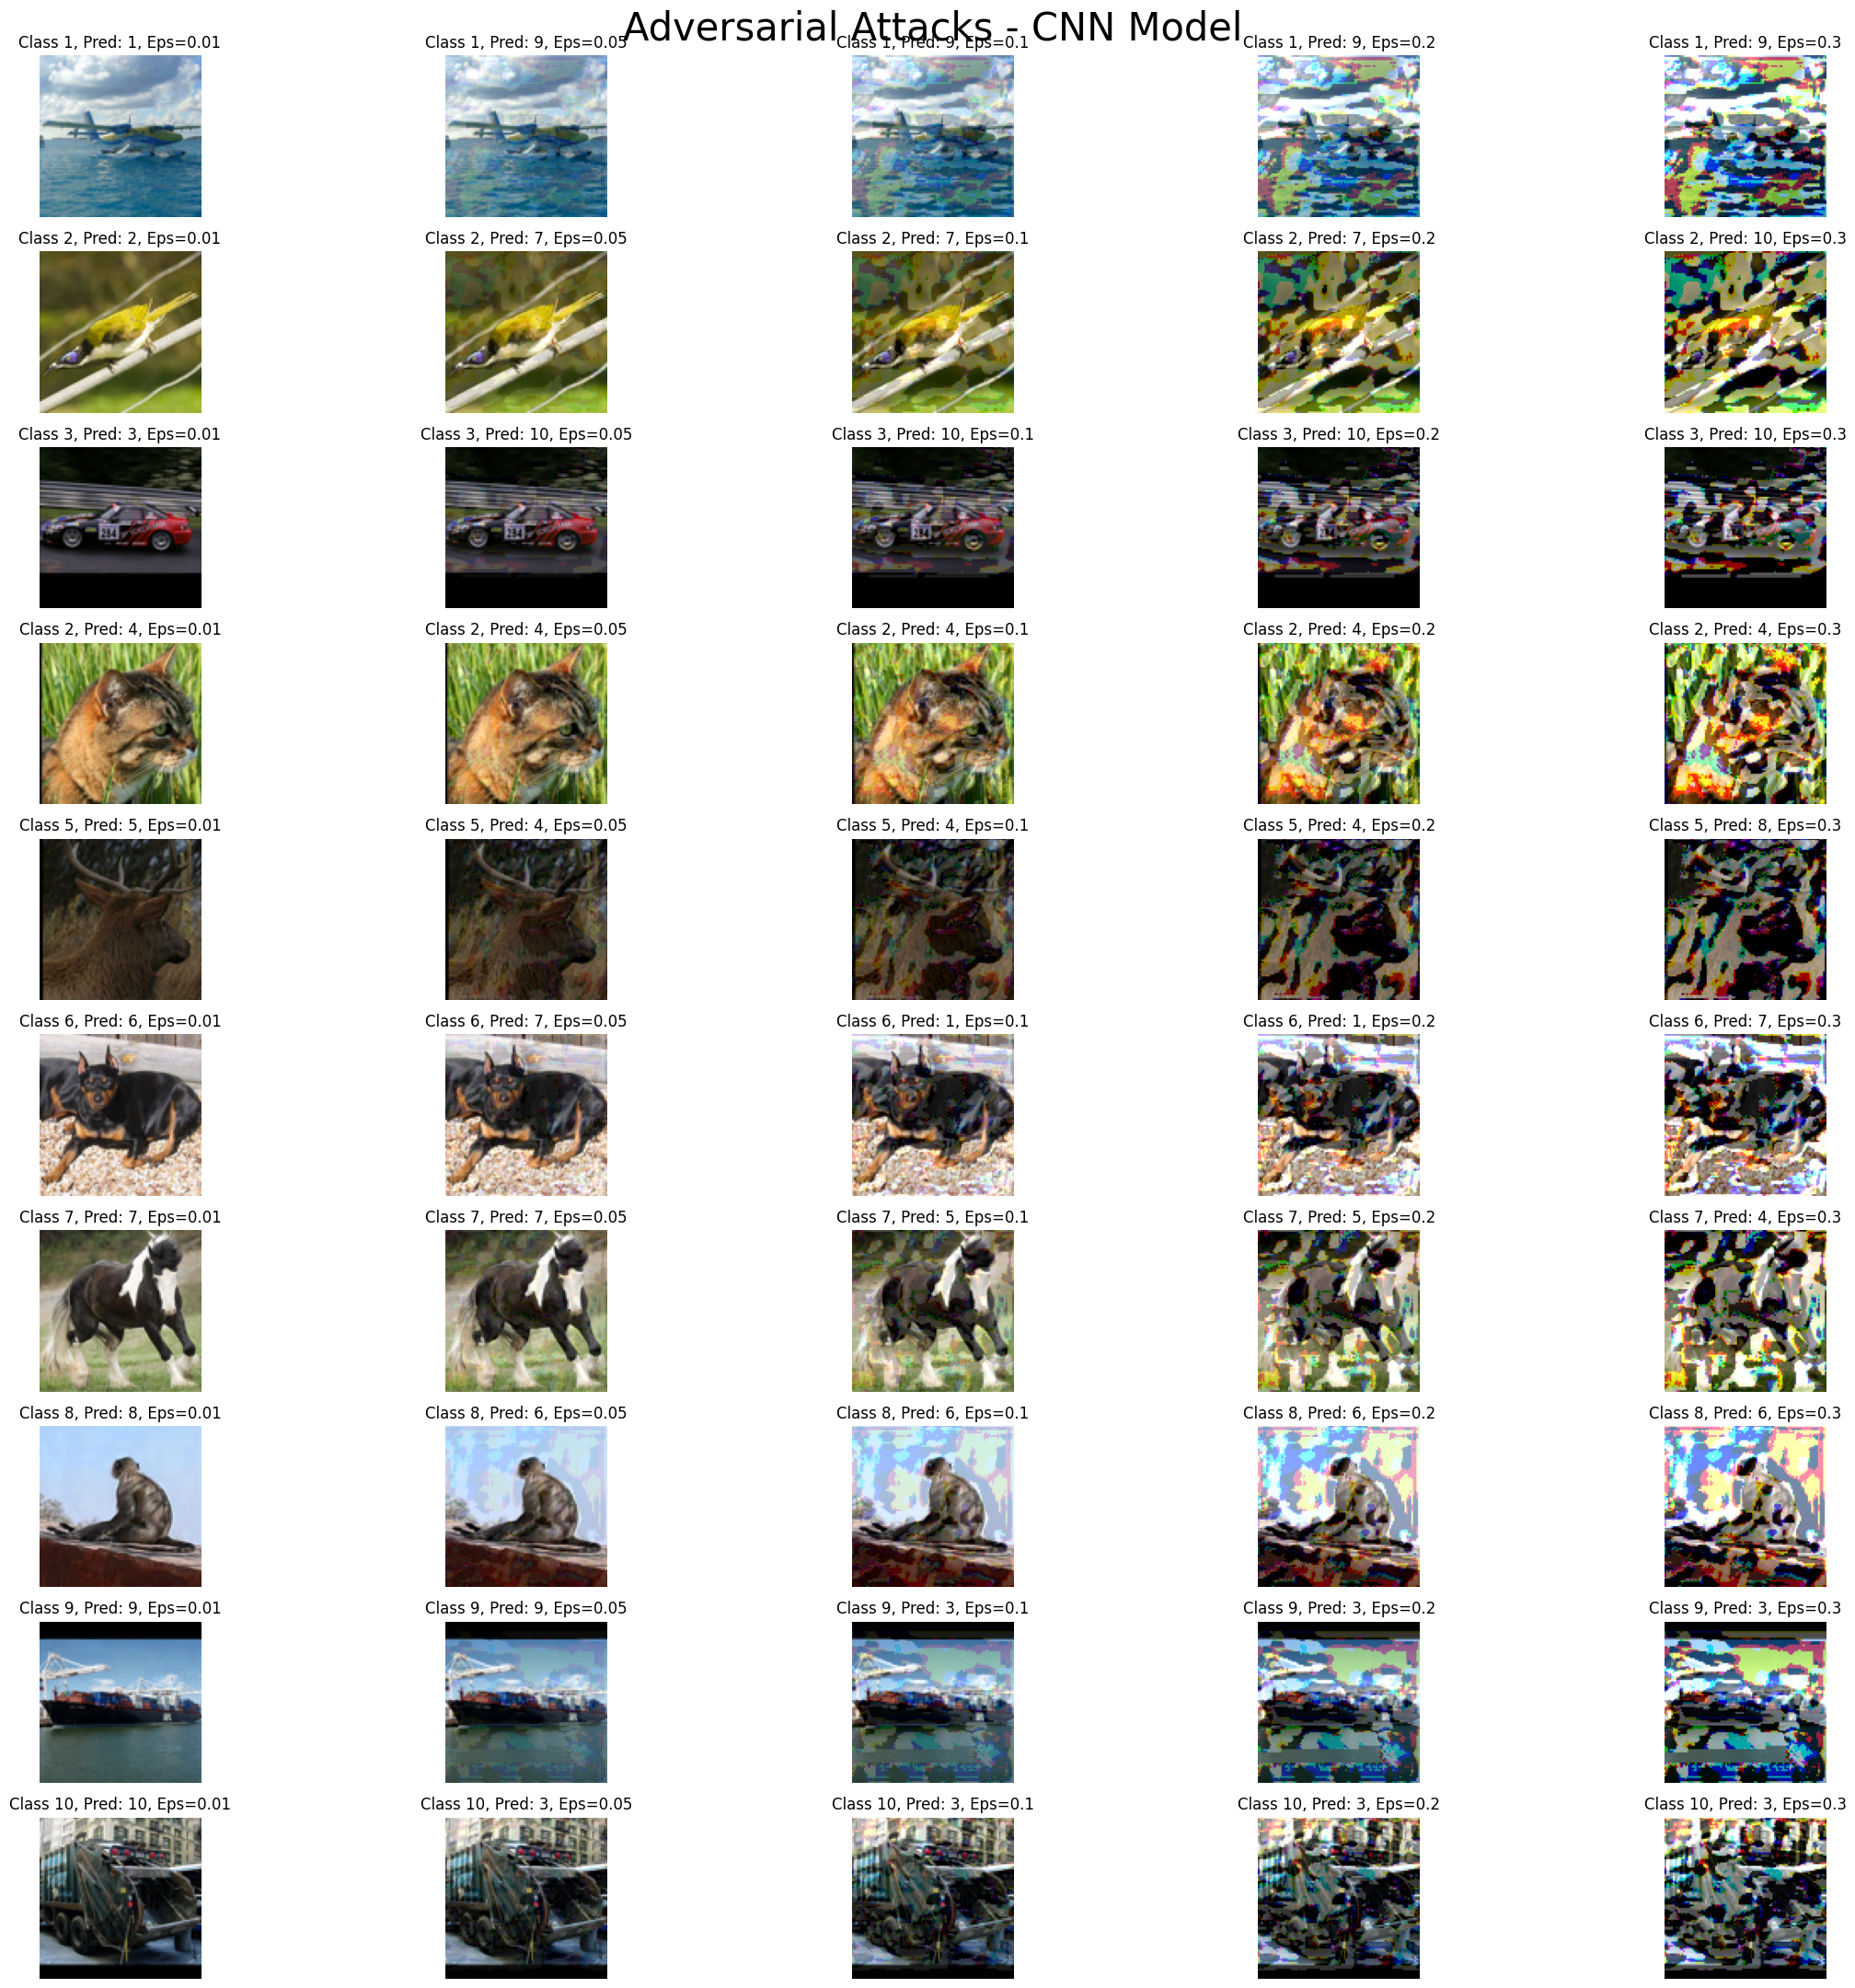

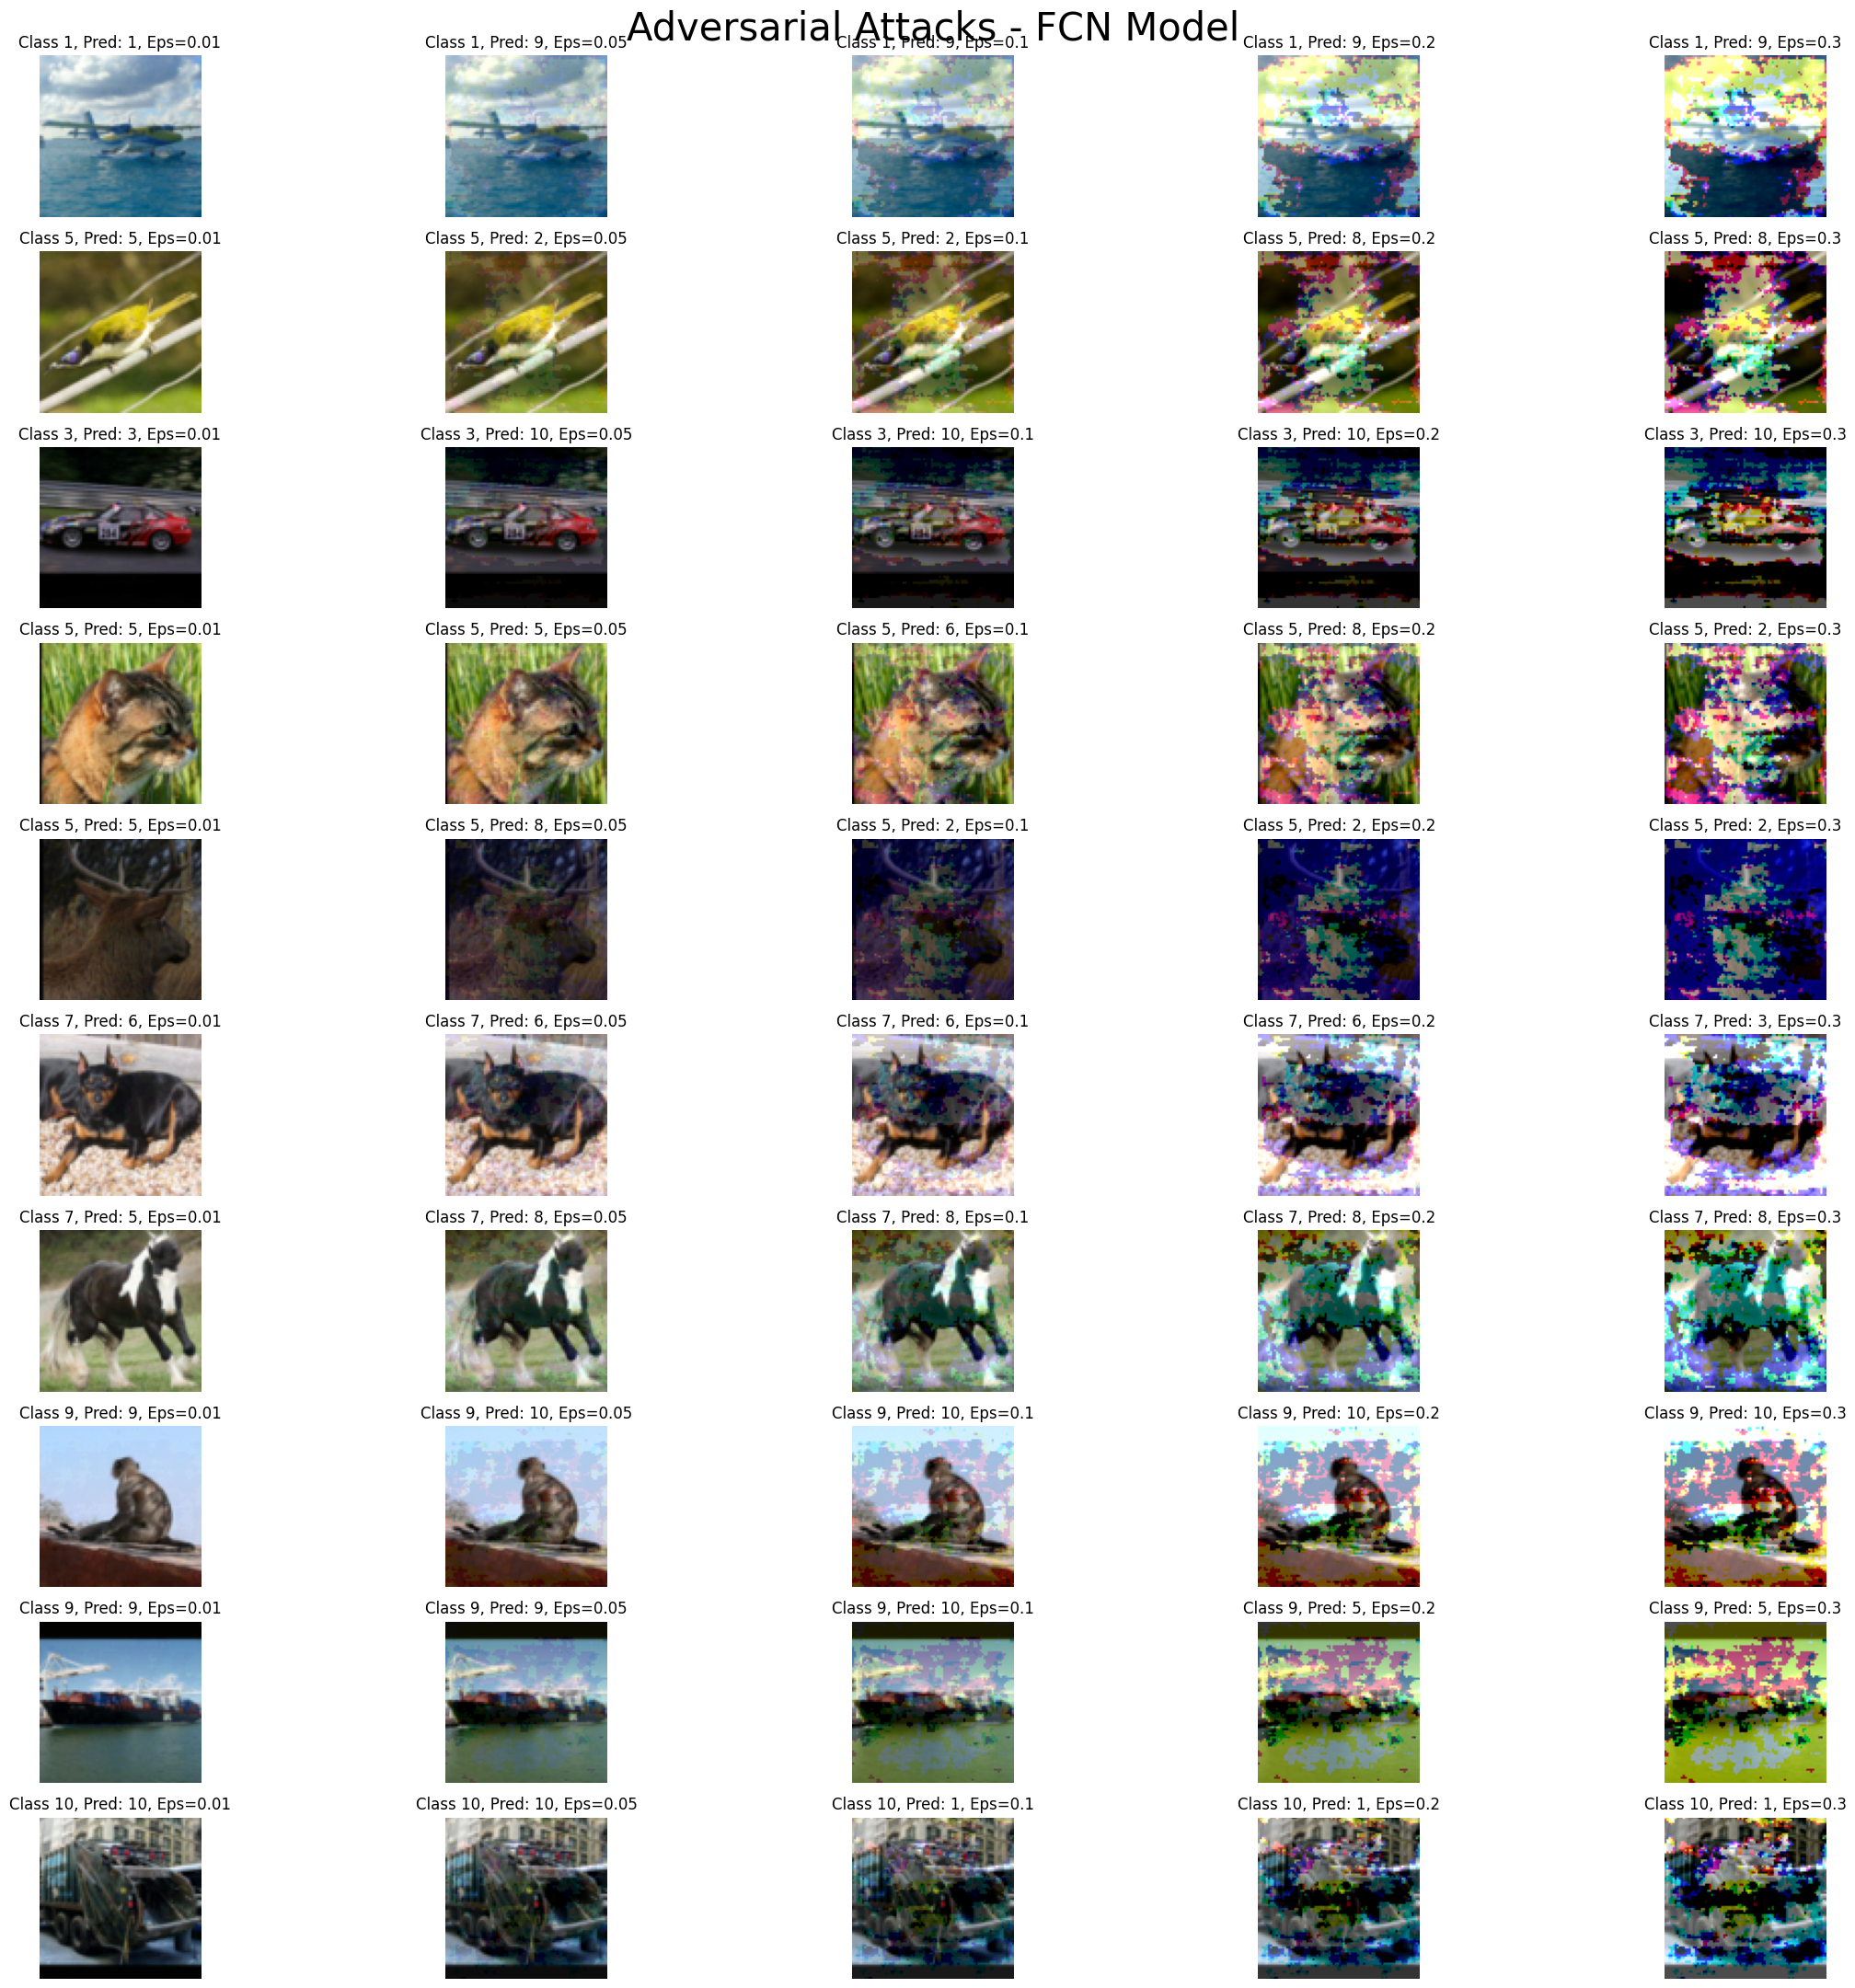

In [88]:
import matplotlib.pyplot as plt

def check(val):
    if (val == 0): 
        return 1
    elif (val == 1):
        return 10
    return val

plt.figure(figsize=(24, 22))
plt.suptitle('Adversarial Attacks - CNN Model', fontsize=30)

for i in range(1, 11):
    for j in range(5):
        plt.subplot(10, 5, (i - 1) * 5 + j + 1)
        plt.imshow(perturbed_images_cnn[i][j])
        plt.title(f'Class {check(labels_cnn[i][j][1])}, Pred: {check(labels_cnn[i][j][0])}, Eps={epsilon_values[j]}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Plotting results for FCN
plt.figure(figsize=(24, 22))
plt.suptitle('Adversarial Attacks - FCN Model', fontsize=30)

for i in range(1, 11):
    for j in range(5):
        plt.subplot(10, 5, (i - 1) * 5 + j + 1)

        plt.imshow(perturbed_images_fcn[i][j])
        plt.title(f'Class {check(labels_fcn[i][j][1])}, Pred: {check(labels_fcn[i][j][0])}, Eps={epsilon_values[j]}')
        plt.axis('off')

plt.tight_layout()
plt.show()
